In [1]:
import sys
sys.path.append('..')
from CompoundPoisson2 import CompoundPoisson2
import time
import numpy as np
import scipy.stats as st
from SAABS import SA
import pandas as pd
import numpy.linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
class SALoss1(SA):
    def __init__(self, X, c, gamma, K, t, init, epsilon, beta, alpha):
        self.__alpha = alpha
        self.__beta = beta
        super(SALoss1, self).__init__(X, c, gamma, K, t, init, epsilon)
    
    @property
    def beta(self):
        return self.__beta
    
    @property
    def alpha(self):
        return self.__alpha
    
    def l(self, m):
        m = np.array(m)
        exp_m = np.exp(m)
        sum_m = np.sum(m)
        s1, s2 = np.sum(self.beta * exp_m), np.exp(self.beta * sum_m)
        return (1 / (1 + self.alpha)) * (s1 + self.alpha * s2) - (self.dim + self.alpha)/ (1 + self.alpha)
        
    
    def grad(self, m):
        m = np.array(m)
        sum_m = np.sum(m)
        common_exp = np.exp(self.beta * sum_m * np.ones(self.dim))
        exp_m = np.exp(self.beta * m)
        return (self.beta / (1 + self.alpha)) * (exp_m + self.alpha * common_exp)


#closed formula in 2d and gaussian distribution
def closedForm2d(covariance, beta, alpha):
    sigma = [np.sqrt(covariance[0][0]), np.sqrt(covariance[1][1])]
    rho = covariance[0][1] / (sigma[0] * sigma[1])
    res = np.array([beta * covariance[0][0] / 2, beta * covariance[1][1] / 2])
    if alpha == 0:
        return res
    num = alpha * np.exp(rho * beta ** 2 * sigma[0] * sigma[1])
    denom = -1 + np.sqrt(1 + alpha * (alpha + 2) * np.exp(rho * beta ** 2 * sigma[0] * sigma[1]))
    SRC = np.log( num / denom)
    return res + (1 / beta) * SRC * np.ones(2)

In [3]:
#Gaussian
#Case: rho = 0, alpha = 1
#M is the length of the sample

np.random.seed(seed=0)
M = 100000
#correlation between the gaussian distributions
corr = 0
#mu is the mean of the gaussian vector
mu = [0., 0.]
covariance = [[1., corr], [corr, 1.]]
rv = st.multivariate_normal(mean = mu, cov = covariance, allow_singular = True)
distr = rv.rvs(size = M)
#alpha is the systemic weight
alpha = 1.
#c, gamma of the SA
c, gamma  = 1., 1
#K the projection compact
K = [[0, 2], [0, 2], [0, 2]]
#t for the window of averaging
t = 10
#epsilon for the calculation of the approximation of the Jacobian matrix A
epsilon = 10 ** (-6)
#init is Z_0 of the SA
init = [0, 0, 0]
#beta of the loss function
beta = 1.
start_time = time.time()
loss = SALoss1(distr, c, gamma, K, t, init, epsilon, beta, alpha)
#Z1 with gamma = 1
Z1 = loss.setRM()
print("Computation Time RM Algorithm: %s seconds ---" % (time.time() - start_time))
#Z1 with gamma = 1
gamma = 0.7
loss = SALoss1(distr, c, gamma, K, t, init, epsilon, beta, alpha)
Z0 = loss.setRM()
#closed formula for this case
exactOpt = closedForm2d(covariance, beta, alpha)
exact = [exactOpt[0] for _ in range(M)]

Computation Time RM Algorithm: 4.129224538803101 seconds ---


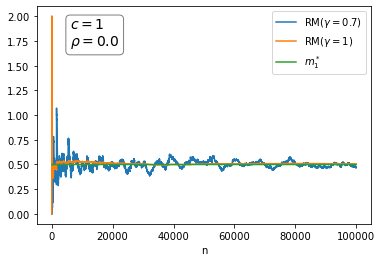

In [4]:
sample_size = [i for i in range(1, M + 1)]
fig, ax = plt.subplots()
textstr = '\n'.join((
    r'$c=%.f$' %(c, ),
    r'$\rho=%.1f$'%(corr, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.plot(sample_size, Z0[0], label = r'RM($\gamma = 0.7$)')
plt.plot(sample_size, Z1[0], label = r'RM($\gamma = 1$)')
plt.plot(sample_size, exact, label = r'$m_1^*$')
plt.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.xlabel('n')
plt.legend()

In [5]:
#PR averaging
#estimation of Sigma* and the jacobian matrix A
loss.setEst()
zBar, CI = loss.getPR()
print(zBar)

[0.49642875 0.50494228 0.9965706 ]
